In [1]:
!pip install spacy

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
accelerate                0.31.0
aiohappyeyeballs          2.4.3
aiohttp                   3.11.8
aiosignal                 1.3.1
annotated-types           0.7.0
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             5.0.1
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
blis                      1.0.1
catalogue                 2.0.10
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
click                     8.1.7
cloudpathlib              0.20.0
comm                      0.2.2
confection                0.1.5
contourpy                 1.3.1
cycler                    0.12.1
cymem   

In [4]:
!pip show transformers

Name: transformers
Version: 4.44.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft


/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU available: NVIDIA A16


/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|████████████████████████████████████████████████████████████████████████| 8478/8478 [00:01<00:00, 5775.61 examples/s]
/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.597800,0.588355,0.830267,0.822953,0.830189,0.830267
1,0.399800,0.425485,0.873201,0.870718,0.869937,0.873201



Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.78      0.78       778
             Bipolar       0.78      0.72      0.75       575
          Depression       0.79      0.95      0.86      3081
              Normal       0.96      0.87      0.91      3270
Personality disorder       0.38      0.44      0.41       240
              Stress       0.58      0.26      0.36       534

            accuracy                           0.83      8478
           macro avg       0.71      0.67      0.68      8478
        weighted avg       0.83      0.83      0.82      8478


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.82      0.81       778
             Bipolar       0.82      0.79      0.80       575
          Depression       0.90      0.91      0.91      3081
              Normal       0.92      0.94      0.93      3270
Personality disord

/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Test Set Metrics:
Accuracy: 0.8732
Precision: 0.8699
Recall: 0.8732
F1 Score: 0.8707


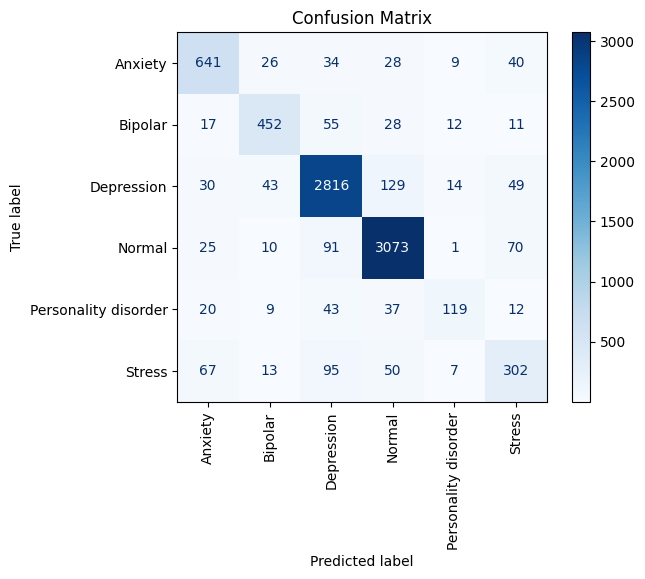


 Saving predictions from the dataset 'traintest_EmotionClassification_predictions.csv'.

 Saved (test set) predictions from the dataset 'traintest_EmotionClassification_predictions.csv'.


In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import spacy
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set up the assigned GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
seed = 42

# Set random seed for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == "cuda":
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    print('GPU is not available')

# Load SpaCy for preprocessing
nlp = spacy.load("en_core_web_sm")

# Tokenization and lemmatization
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text.lower())
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(lemmatized_tokens)

# Load the dataset
file_path = "MentalHealthDataset.csv"
df = pd.read_csv(file_path)

# Remove rows with status "Suicidal"
df = df[df['status'] != "Suicidal"]

# Handle missing values in 'statement' and 'status' columns
df['statement'] = df['statement'].fillna("")
df = df.dropna(subset=['status'])

# Preprocess text in the dataset
df['processed_statement'] = df['statement'].apply(preprocess_text)

# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['processed_statement'].tolist(),
    df['status'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['status']
)

# Map class labels to integers
unique_labels = sorted(df['status'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Convert labels to integers
train_labels = [label2id[label] for label in train_labels]
test_labels = [label2id[label] for label in test_labels]

# Convert data to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

# Load tokenizer and RoBERTa model
model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fine tune model
fine_tuned_model_path = "fine_tuned_roberta_model"
print("Training model")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels))

# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

# Ensure train and test datasets are tokenized
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",          
    save_strategy="epoch",          
    learning_rate=5e-5,             
    per_device_train_batch_size=2,  
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  
    num_train_epochs=2,             
    weight_decay=0.01,
    load_best_model_at_end=True,    
    save_total_limit=1,             
    fp16=True,                      
)
# Compute Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=unique_labels))
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained(fine_tuned_model_path)
tokenizer.save_pretrained(fine_tuned_model_path)

# Evaluate the model on the test set
print("\n Evaluating the model on the Test Set : ")
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions_output = trainer.predict(test_dataset)

# Extract logits and convert to predicted labels
logits = predictions_output.predictions
predicted_labels = np.argmax(logits, axis=1)

# Map integer labels back to their string names
predicted_classes = [id2label[label] for label in predicted_labels]

# Calculate Metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average="weighted")

# Display the metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Save the test results to a CSV file
print("\n Saving predictions from the dataset 'traintest_EmotionClassification_predictions.csv'.")
test_results = pd.DataFrame({
    "Text": test_texts,
    "True Label": [id2label[label] for label in test_labels],
    "Predicted Label": predicted_classes
})
test_results.to_csv("traintest_EmotionClassification_predictions.csv", index=False)
print("\n Saved (test set) predictions from the dataset 'traintest_EmotionClassification_predictions.csv'.")